In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="notebook", style="white", palette=sns.color_palette("RdBu"), color_codes=False)
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report

# Anomaly detection

## load data

In [2]:
mat = sio.loadmat('./data/ex8data1.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [3]:
X = mat.get('X')
Xval, Xtest, yval, ytest = train_test_split(mat.get('Xval'), mat.get('yval'), test_size=0.5)

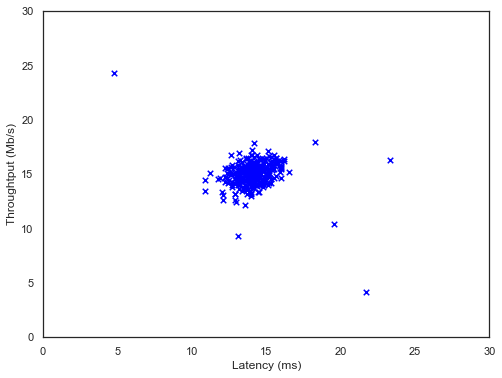

In [4]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlabel('Latency (ms)')
ax.set_ylabel('Throughtput (Mb/s)')
ax.set_xlim(0, 30)
ax.set_ylim(0, 30)
ax.scatter(X[:,0], X[:, 1], marker='x', c='b', s=30)
plt.show()

## Gaussian distribution

![](img/Gaussian_distribution.png)

In [5]:
mu = X.mean(axis=0)
mu

array([14.11222578, 14.99771051])

In [6]:
sigma2 = ((X - mu)**2).sum(axis=0) / X.shape[0]
sigma2

array([1.83263141, 1.70974533])

In [7]:
def pdf(x, mu, sigma2):
    m, n = x[0].shape
    ret = 1 / np.power(2*np.pi*sigma2, n/2) * np.exp(-(x-mu)*(x-mu) / (2*sigma2))
    ret = ret.prod(axis=2)
    return  ret

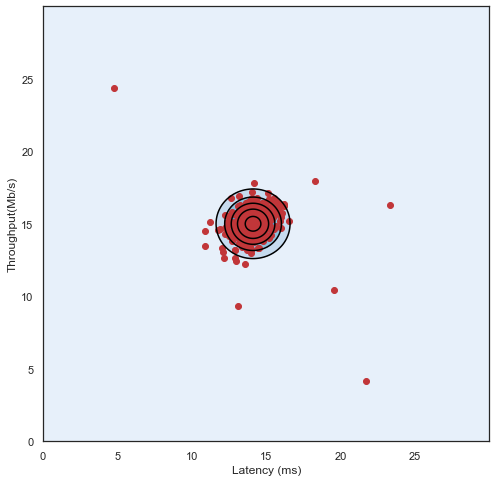

In [8]:
x, y = np.mgrid[0:30:0.01, 0:30:0.01]
pos = np.dstack((x, y))
fig, ax = plt.subplots(figsize=(8, 8))
ax.contourf(x, y, pdf(pos, mu, sigma2), cmap='Blues')
ax.contour(x, y, pdf(pos, mu, sigma2), colors='black')

ax.set_xlabel('Latency (ms)')
ax.set_ylabel('Throughput(Mb/s)')
ax.scatter(X[:, 0], X[:, 1])

plt.show()

## multivariate Gaussian parameters

In [9]:
mu = X.mean(axis=0)
mu

array([14.11222578, 14.99771051])

In [10]:
cov = np.cov(X.T)
cov

array([[ 1.83862041, -0.22786456],
       [-0.22786456,  1.71533273]])

In [11]:
multi_normal = stats.multivariate_normal(mu, cov)

In [12]:
x, y = np.mgrid[0:30:0.01, 0:30:0.01]
pos = np.dstack((x, y))

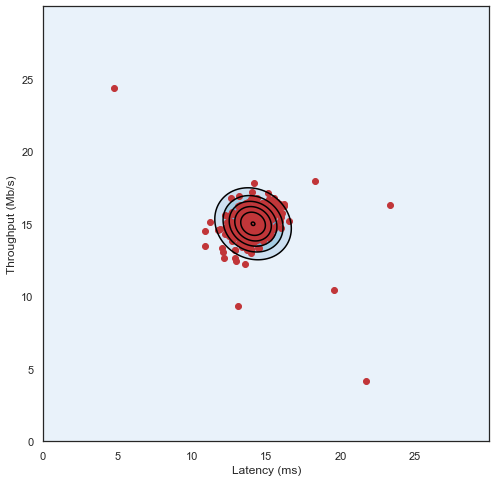

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.contourf(x, y, multi_normal.pdf(pos), cmap='Blues')
ax.contour(x, y, multi_normal.pdf(pos), colors='black')

ax.set_xlabel('Latency (ms)')
ax.set_ylabel('Throughput (Mb/s)')
ax.scatter(X[:, 0], X[:, 1])

plt.show()

## select threshold $\epsilon$

using the $F_1$ score on a cross validation set.

![](img/F1_score.png)

In [14]:
def select_threshold(X, Xval, yval):
    '''
    use CV data to find the best epsilon
    Returns:
        e: best epslion with the highest F-score
        f-score
    '''
    # create multivariate model using traing data
    mu = X.mean(axis=0)
    cov = np.cov(X.T)
    multi_normal = stats.multivariate_normal(mu, cov)
    
    pval = multi_normal.pdf(Xval)
    epsilon = np.linspace(np.min(pval), np.max(pval), num=10000)
    
    fs = []
    for e in epsilon:
        y_pred = (pval <= e).astype('int')
        fs.append(f1_score(yval, y_pred))
        
    argmax_fs = np.argmax(fs)
    
    return epsilon[argmax_fs], fs[argmax_fs]    

In [15]:
e, fs = select_threshold(X, Xval, yval)
print('Best epsilon: {}\nBest F-score on validation data: {}'.format(e, fs))

Best epsilon: 2.7101600950148493e-05
Best F-score on validation data: 0.8


In [16]:
def predict (X, Xval, e, Xtest, ytest):
    '''
    Returns:
        multi_normal: multivariate normal model
        y_pred: prediction of test data
    '''
    
    Xdata = np.concatenate((X, Xval), axis=0)
    mu = Xdata.mean(axis=0)
    cov = np.cov(Xdata.T)
    multi_normal = stats.multivariate_normal(mu, cov)
    
    pval = multi_normal.pdf(Xtest)
    y_pred = (pval <= e).astype('int')
    print(classification_report(ytest, y_pred))
    
    return multi_normal, y_pred

In [17]:
multi_normal, y_pred = predict(X, Xval, e, Xtest, ytest)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       148
           1       1.00      0.83      0.91         6

    accuracy                           0.99       154
   macro avg       1.00      0.92      0.95       154
weighted avg       0.99      0.99      0.99       154



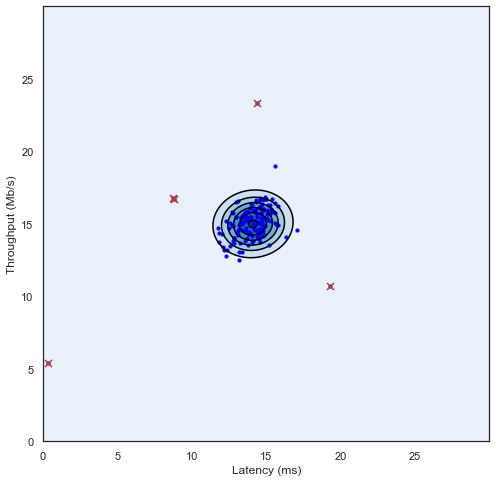

In [18]:
data = pd.DataFrame(Xtest, columns=['Latency', 'Throughput'])
data['y_pred'] = y_pred

fig, ax = plt.subplots(figsize=(8, 8))
ax.contourf(x, y, multi_normal.pdf(pos), cmap='Blues')
ax.contour(x, y, multi_normal.pdf(pos), colors='black')

ax.set_xlabel('Latency (ms)')
ax.set_ylabel('Throughput (Mb/s)')
ax.scatter(Xtest[:, 0], Xtest[:, 1], c='b', s=10)

anamoly_data = data[data['y_pred'] == 1]
ax.scatter(anamoly_data['Latency'], anamoly_data['Throughput'], marker='x', s=50)

plt.show()

## high dimension data

In [19]:
mat = sio.loadmat('./data/ex8data2.mat')

X = mat.get('X')
Xval, Xtest, yval, ytest = train_test_split(mat.get('Xval'), mat.get('yval').ravel(), test_size=0.5)

In [20]:
e, fs = select_threshold(X, Xval, yval)
print('Best epsion: {}\nBest F-Score on validation data: {}'.format(e, fs))

Best epsion: 1.7467367702857123e-19
Best F-Score on validation data: 0.888888888888889


In [21]:
multi_normal, y_pred = predict(X, Xval, e, Xtest, ytest)

              precision    recall  f1-score   support

           0       0.93      0.98      0.96        44
           1       0.75      0.50      0.60         6

    accuracy                           0.92        50
   macro avg       0.84      0.74      0.78        50
weighted avg       0.91      0.92      0.91        50



In [22]:
print('find {} anamolies in Xtest data set'.format(y_pred.sum()))

find 4 anamolies in Xtest data set


In [23]:
yval = multi_normal.pdf(X)
y_pred = (yval <= e).astype('int')
print('find {} anamolies in X data set'.format(y_pred.sum()))

find 34 anamolies in X data set
